In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import field, asdict, dataclass
from typing import List
from benchmarks.benchmark_utils import RequestFuncOutput
from benchmarks.benchmark_workload_gen import *

In [2]:
def retrive_request_outputs(path):
    with open(path, 'r') as file:
        data = json.load(file)
        outputs = [RequestFuncOutput(**d) for d in data]
    return outputs

In [5]:
def lat_tpot_ttft(outputs: List[RequestFuncOutput], match = None):
    if not match:
        match = lambda o: True
    outputs = [o for o in outputs if match(o)]
    lats = [o.request_latency for o in outputs if o.request_latency]
    tpots = [o.tpot for o in outputs if o.tpot]
    ttfts = [o.ttft for o in outputs if o.ttft]
    lat_p50, lat_p90, lat_p99 = np.percentile(lats, [50, 90, 99])
    tpot_p50, tpot_p90, tpot_p99 = np.percentile(tpots, [50, 90, 99])
    ttft_p50, ttft_p90, ttft_p99 = np.percentile(ttfts, [50, 90, 99])
    
    print(f"Num finished: {len([o for o in outputs if o.success])}")
    print(f'Latency: p50={lat_p50:.2f}, p90={lat_p90:.2f}, p99={lat_p99:.2f}')
    print(f'TPOT: p50={tpot_p50:.2f}, p90={tpot_p90:.2f}, p99={tpot_p99:.2f}')
    print(f'TTFT: p50={ttft_p50:.2f}, p90={ttft_p90:.2f}, p99={ttft_p99:.2f}')
    
    fig, axs = plt.subplots(1,3, figsize=(16, 4))
    sns.kdeplot(x=lats,  ax=axs[0], cumulative=True).set_title('Latency')
    sns.kdeplot(x=tpots, ax=axs[1], cumulative=True).set_title('TPOT')
    sns.kdeplot(x=ttfts, ax=axs[2], cumulative=True).set_title('TTFT')
    
def ttft_slo(outputs, slo):
    ttfts = [o.ttft for o in outputs if o.ttft]
    slo_ttfts = [1 for ttft in ttfts if ttft <= slo]
    return sum(slo_ttfts) / len(ttfts)

def windowed_metric(start, end, outputs: List[RequestFuncOutput], exp_time, match = None):
    if not match:
        match = lambda o: True
    within_window = [o for o in outputs if o.send_out_time >= start and o.send_out_time <= end and match(o)]
    lats = [o.request_latency if o.success else exp_time - o.send_out_time for o in within_window]
    tpots = [o.tpot for o in within_window if o.tpot]
    ttfts = [o.ttft if o.ttft else exp_time - o.send_out_time for o in within_window]
    lat_p50, lat_p90, lat_p99 = np.percentile(lats, [50, 90, 99])
    tpot_p50, tpot_p90, tpot_p99 = np.percentile(tpots, [50, 90, 99])
    ttft_p50, ttft_p90, ttft_p99 = np.percentile(ttfts, [50, 90, 99])
    avg_lat, avg_tpot, avg_ttft = np.mean(lats), np.mean(tpots), np.mean(ttfts)
    
    print('-'*20)
    print(f"Requests within window: {len(within_window)}")
    print(f"Num finished: {len([o for o in within_window if o.success])}")
    print(f'Latency: p50={lat_p50:.2f}, p90={lat_p90:.2f}, p99={lat_p99:.2f}')
    print(f'TPOT: p50={tpot_p50:.2f}, p90={tpot_p90:.2f}, p99={tpot_p99:.2f}')
    print(f'TTFT: p50={ttft_p50:.2f}, p90={ttft_p90:.2f}, p99={ttft_p99:.2f}')
    print(f'Avg Latency: {avg_lat:.2f}, Avg TPOT: {avg_tpot:.2f}, Avg TTFT: {avg_ttft:.2f}')
    print('-'*20)

In [6]:
is_cold = lambda o: not WorkloadPrefixDataLoader.is_hot(o)

In [11]:
ref_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/ref_eq_v2_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_1200_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_600')
sim_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/sim_eq_v2_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_1200_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_600')
sim_sleep_random = retrive_request_outputs('/mnt/ssd1/alm-os/sglang_multi_model/logs/sim_sleep_eq_v2_16K_2r_1800_rps_2/mistralai-Mistral-7B-v0.1_24_0.5_1200_2_DataParallelRuntimeSelectionPolicy.RANDOM-None:4r_600')

Num finished: 41
Latency: p50=116.39, p90=383.19, p99=416.69
TPOT: p50=0.26, p90=0.38, p99=0.44
TTFT: p50=105.68, p90=361.51, p99=398.94
Num finished: 40
Latency: p50=52.68, p90=376.06, p99=451.19
TPOT: p50=0.25, p90=0.43, p99=0.50
TTFT: p50=35.11, p90=357.69, p99=432.20
Num finished: 40
Latency: p50=104.15, p90=336.34, p99=365.19
TPOT: p50=0.28, p90=0.40, p99=0.45
TTFT: p50=90.13, p90=315.60, p99=342.93


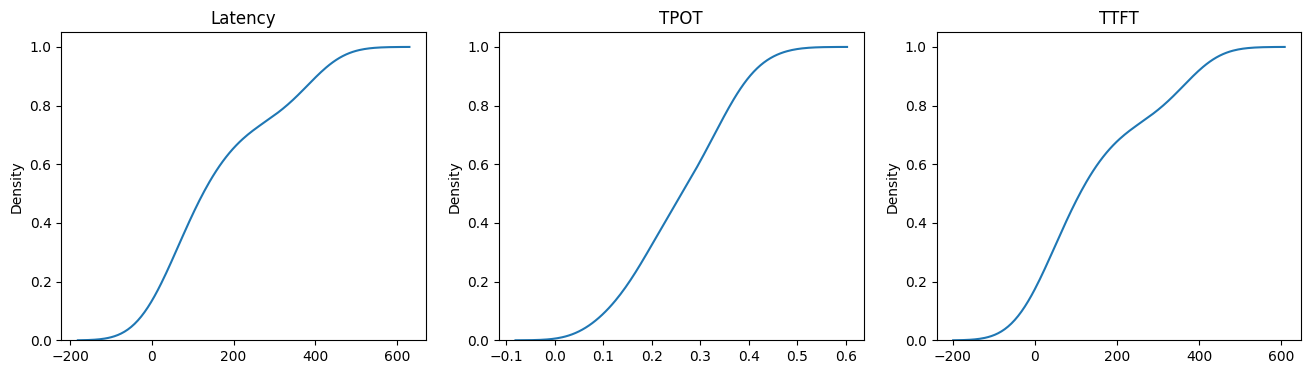

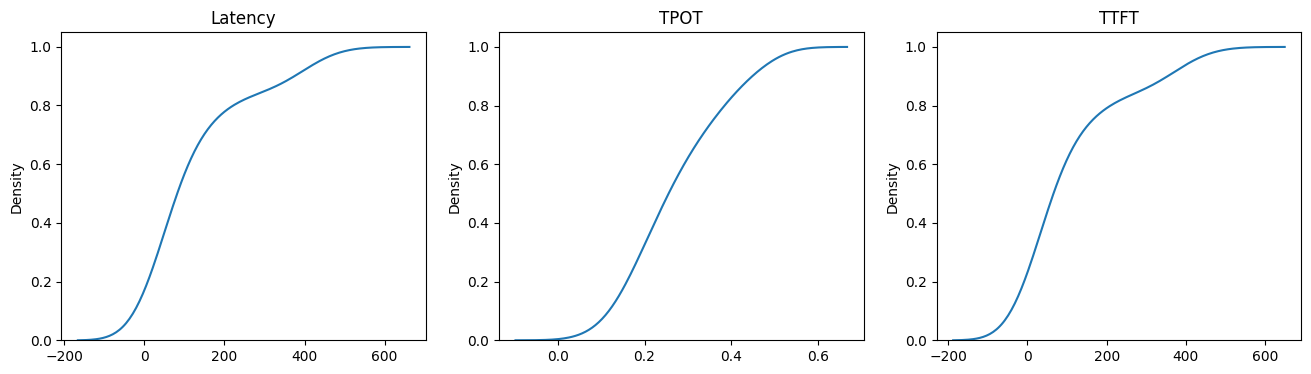

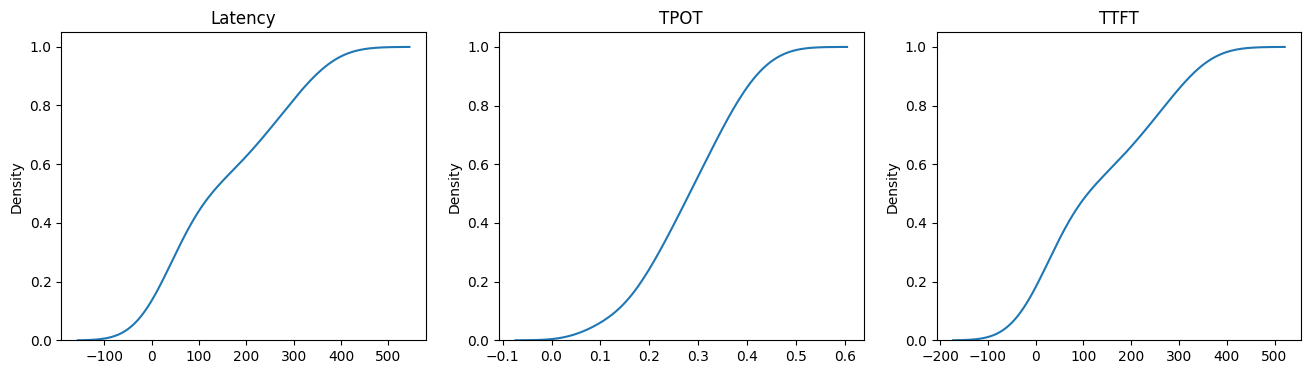

In [12]:
lat_tpot_ttft(ref_random, is_cold)
lat_tpot_ttft(sim_random, is_cold)
lat_tpot_ttft(sim_sleep_random, is_cold)

Num finished: 573
Latency: p50=30.91, p90=51.33, p99=101.56
TPOT: p50=0.31, p90=0.42, p99=0.49
TTFT: p50=9.27, p90=30.58, p99=82.40
Num finished: 563
Latency: p50=31.03, p90=66.87, p99=143.28
TPOT: p50=0.32, p90=0.44, p99=0.50
TTFT: p50=9.31, p90=45.85, p99=121.05
Num finished: 579
Latency: p50=29.95, p90=48.09, p99=96.37
TPOT: p50=0.29, p90=0.40, p99=0.47
TTFT: p50=9.73, p90=26.64, p99=79.43


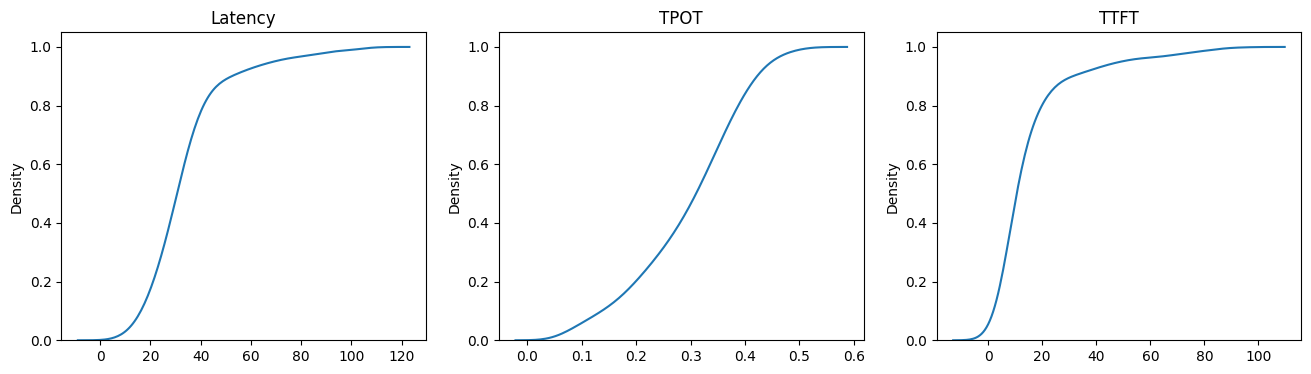

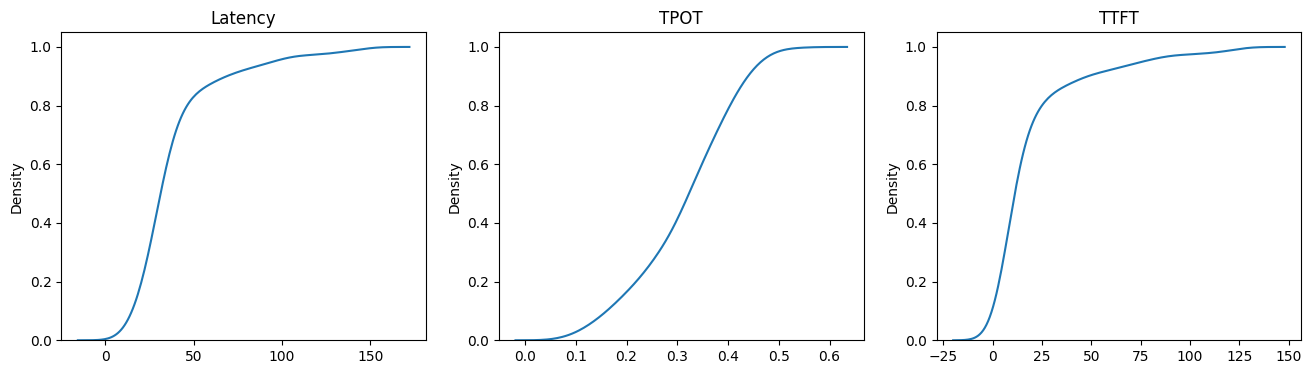

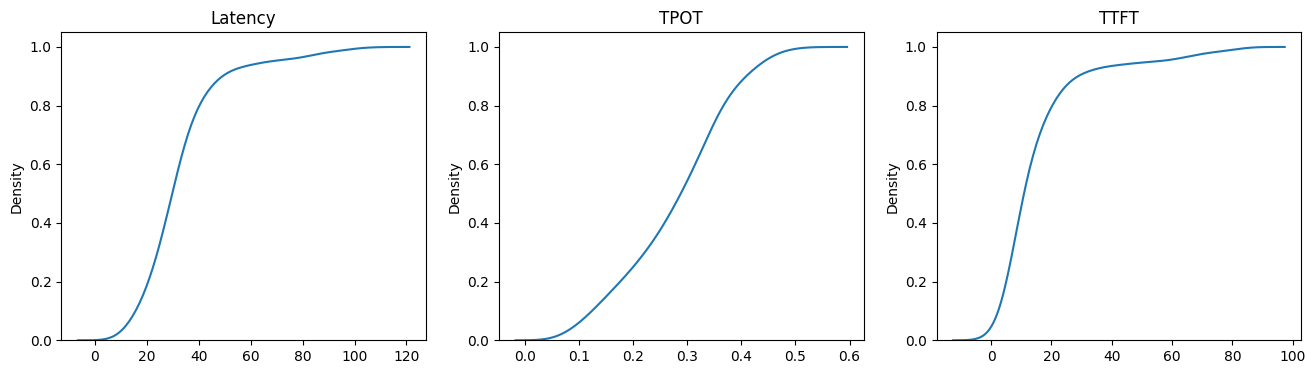

In [13]:
lat_tpot_ttft(ref_random, WorkloadPrefixDataLoader.is_hot)
lat_tpot_ttft(sim_random, WorkloadPrefixDataLoader.is_hot)
lat_tpot_ttft(sim_sleep_random, WorkloadPrefixDataLoader.is_hot)